In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as mp
import os

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
frog


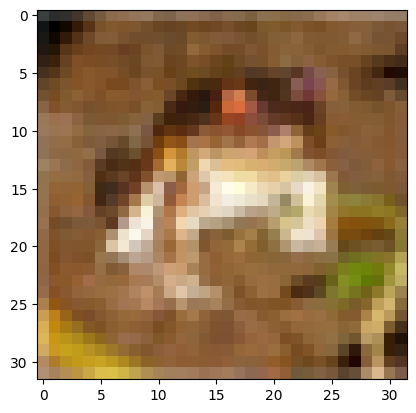

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
#classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
#x_train = tf.expand_dims(x_train, axis=-1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
mp.imshow(x_train[0])
print(classes[y_train[0][0]])

In [4]:
image_size = 32
patch_size = 8
no_patch = int((image_size / patch_size) ** 2)
no_channels = 3
hidden_dim = 256
input_shape = (image_size, image_size, no_channels)
multi_attn_head = 12
mlp_expn_ratio = 4
no_classes = len(classes)

In [5]:
class Extra_Layer(tf.keras.layers.Layer):
    def __init__(self, name='extra_layer'):
        super(Extra_Layer, self).__init__(name=name)
        return
    def build(self, input_shape):
        outer_dim = input_shape[-1]
        self.w = self.add_weight(name='extra_w', shape=(1, 1, outer_dim), initializer=tf.random_normal_initializer(), trainable=True)
        return
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        broadcasted = tf.broadcast_to(self.w, (batch_size, 1, inputs.shape[-1]))
        casted_broadcast = tf.cast(broadcasted, inputs.dtype)
        return tf.concat([inputs, casted_broadcast], axis=1)

In [6]:
inputs = tf.keras.layers.Input(shape=input_shape)
patches = tf.image.extract_patches(inputs, sizes=[1, patch_size, patch_size, 1], strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
patches = tf.reshape(patches, shape=(-1, no_patch, patch_size * patch_size * no_channels))
positions = tf.range(0, limit=no_patch, delta=1)
patch_embed = tf.keras.layers.Dense(units=hidden_dim)(patches)
position_embed = tf.keras.layers.Embedding(input_dim=no_patch, output_dim=hidden_dim)(positions)
embed = patch_embed + position_embed
print(embed.shape)
embed = Extra_Layer()(embed)
print(embed.shape)

(None, 16, 256)
(None, 17, 256)


In [7]:
for _ in range(8):
    skip = embed
    #embed = tf.keras.layers.BatchNormalization(epsilon=1e-6)(embed)
    embed = tf.keras.layers.LayerNormalization()(embed)
    embed = tf.keras.layers.MultiHeadAttention(num_heads=multi_attn_head, key_dim=hidden_dim)(embed, embed)
    embed = tf.keras.layers.Add()([embed, skip])

    skip = embed
    #embed = tf.keras.layers.BatchNormalization(epsilon=1e-6)(embed)
    embed = tf.keras.layers.LayerNormalization()(embed)
    embed = tf.keras.layers.Dense(units=(512), activation='gelu')(embed)
    embed = tf.keras.layers.Dropout(rate=0.1)(embed)
    embed = tf.keras.layers.Dense(units=256)(embed)
    embed = tf.keras.layers.Dropout(rate=0.1)(embed)
    embed = tf.keras.layers.Add()([embed, skip])

In [8]:
#embed = tf.keras.layers.BatchNormalization(epsilon=1e-6)(embed)
embed = tf.keras.layers.LayerNormalization()(embed)
embed = tf.keras.layers.Flatten()(embed)
embed = tf.keras.layers.Dropout(rate=0.1)(embed)

embed = tf.keras.layers.Dense(units=(2048), activation='gelu')(embed)
embed = tf.keras.layers.Dropout(rate=0.5)(embed)
embed = tf.keras.layers.Dense(units=1024)(embed)
embed = tf.keras.layers.Dropout(rate=0.5)(embed)
logits = tf.keras.layers.Dense(units=no_classes)(embed)

model = tf.keras.Model(inputs=inputs, outputs=logits)

In [9]:
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["acc"]
)

model.fit(
    x=x_train,
    y=y_train,
    epochs=40,
    validation_data=(x_test, y_test),
    batch_size=250
)

#model.predict(x_test)

Epoch 1/40
200/200 [==============================] - 51s 226ms/step - loss: 2.8853 - acc: 0.2079 - val_loss: 1.9155 - val_acc: 0.3001
Epoch 2/40
200/200 [==============================] - 44s 219ms/step - loss: 1.9936 - acc: 0.2495 - val_loss: 1.8490 - val_acc: 0.3194
Epoch 3/40
200/200 [==============================] - 44s 221ms/step - loss: 1.9269 - acc: 0.2707 - val_loss: 1.7401 - val_acc: 0.3721
Epoch 4/40
200/200 [==============================] - 45s 225ms/step - loss: 1.8661 - acc: 0.2991 - val_loss: 1.6626 - val_acc: 0.4096
Epoch 5/40
200/200 [==============================] - 45s 226ms/step - loss: 1.8321 - acc: 0.3147 - val_loss: 1.6471 - val_acc: 0.3984
Epoch 6/40
200/200 [==============================] - 44s 222ms/step - loss: 1.7739 - acc: 0.3408 - val_loss: 1.6102 - val_acc: 0.4195
Epoch 7/40
200/200 [==============================] - 44s 222ms/step - loss: 1.7072 - acc: 0.3695 - val_loss: 1.5120 - val_acc: 0.4571
Epoch 8/40
200/200 [==============================] - 4

KeyboardInterrupt: 

In [12]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 9s 24ms/step - loss: 1.2133 - acc: 0.5702


[1.2132948637008667, 0.5702000260353088]

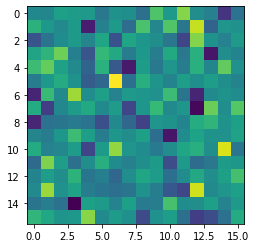

In [11]:
layer = model.get_layer('extra_layer')
weights = layer.get_weights()
res = tf.reshape(tf.squeeze(weights[0]), shape=(16, 16, 1))
mp.imshow(res)

In [ ]:
def plot_accs(plot_iters, test_acc):
    mp.cla()
    mp.ylim(0.0, 1.0)
    mp.xlabel('No. of Iterations')
    mp.ylabel('Accuracy')
    plot_iters_smooth = np.linspace(np.min(plot_iters), np.max(plot_iters), 250)
    xy_spline = ip.make_interp_spline(plot_iters, test_acc)
    test_acc_smooth = xy_spline(plot_iters_smooth)
    mp.plot(plot_iters_smooth, test_acc_smooth)
    fig = mp.gcf()
    fig.set_size_inches(10, 10)
    fig.savefig('./myrun/vit/cifar10/vit_accuracy')
    return